## Initial analysis

In [1]:
# Install the required libraries (from pip_requirements.txt)
%pip install -r pip_requirements.txt

!python -m spacy download en_core_web_sm


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ----- ---------------------------------- 1.8/12.8 MB 10.1 MB/s eta 0:00:02
     ------------- -------------------------- 4.2/12.8 MB 10.5 MB/s eta 0:00:01
     ------------------- -------------------- 6.3/12.8 MB 11.0 MB/s eta 0:00:01
     --------------------------- ------------ 8.7/12.8 MB 10.3 MB/s eta 0:00:01
     ---------------------------------- ---- 11.3/12.8 MB 10.7 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 10.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
pip install --upgrade nbformat

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Modules to import
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
from importlib import reload

In [4]:
paths = ['src/data','src/models','src/scripts','src/utils']
for path in paths:
    sys.path.append(path)

## I. Data preprocessing

### I.1 Original data

In [5]:
# Execute dataCleaning.py
# This script create dictionaries of freebase_id, convert date to datetime object, transform our columns

%run src/scripts/dataCleaning.py

Movies successfully loaded
Characters successfully loaded
Clusters successfully loaded
Summaries successfully loaded
Dates successfully converted
Build of countries dictionnary...
Build of languages dictionnary...
Build of genres dictionnary...
Build of actors dictionnary...
Build of character dictionnary...
Build of movies dictionnary...
Dictionnaries successfully saved
Saved movies_cleaned to data/cleanData/movies_cleaned.csv
Saved characters_cleaned to data/cleanData/characters_cleaned.csv
Saved character_clusters_cleaned to data/cleanData/character_clusters_cleaned.csv
Saved summaries_cleaned to data/cleanData/summaries_cleaned.csv
Datasets successfully saved
Data cleaning successfully done


Load the data

In [6]:
# Import dataloader function
from dataLoader import loadDataframe

In [7]:
# Load data
path_to_directory = 'data/cleanData/'
df_movies = loadDataframe('movies', path_to_directory)

c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/data\dataLoader.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[columns_to_convert] = df[columns_to_convert].applymap(eval)


### I.2 Additional data

#### I.2.1 Additional movie dataset from Kaggle

Because the revenue is important for the Economics part of our analysis we try to add a new dataset from Kaggle with movies to add more consistency to our results.

The new dataset has the revenue and the budget as interesting features for the Economics analysis.

In [8]:
#Execute additionaldataCleaning.py
#This script create dictionaries of freebase_id, convert date to datetime object, transform our columns TO CHANGE

%run src/scripts/additionaldataCleaning.py

Additional Movies successfully loaded
Monthly inflation data successfully loaded
Budget successfully converted
Filtered additional movie data successfully created
Inflation data successfully processed
Saved Kaggle_US_CPI_monthly_cleaned to data/cleanData/Kaggle_US_CPI_monthly_cleaned.csv
Saved monthly inflation data to Kaggle_US_CPI_monthly_cleaned.csv
Saved Kaggle_US_CPI_annual_cleaned to data/cleanData/Kaggle_US_CPI_annual_cleaned.csv
Saved annual inflation data to Kaggle_US_CPI_annual_cleaned.csv
Saved Kaggle_movie_data_tmdb_cleaned to data/cleanData/Kaggle_movie_data_tmdb_cleaned.csv
Saved additional movie data to Kaggle_movie_data_tmdb_cleaned.csv
Saved Kaggle_movie_data_tmdb_filtered_cleaned to data/cleanData/Kaggle_movie_data_tmdb_filtered_cleaned.csv
Saved filtered additional movie data to Kaggle_movie_data_tmdb_filtered_cleaned.csv


Data statistics overview

In [9]:
from dataLoader import loadAdditionalDataframe

In [10]:
path_to_directory = 'data/cleanData/'
df_inflation_additional_annual = loadAdditionalDataframe('inflation_annual', path_to_directory)
df_inflation_additional_monthly = loadAdditionalDataframe('inflation_monthly', path_to_directory)  
df_movies_additional = loadAdditionalDataframe('movies_additional', path_to_directory)
df_movies_additional_filtered = loadAdditionalDataframe('movies_additional_filtered', path_to_directory)

In [11]:
df_movies_additional.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119931 entries, 0 to 119930
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   imdb_id            114475 non-null  object 
 1   original_title     119392 non-null  object 
 2   original_language  119392 non-null  object 
 3   budget             119074 non-null  float64
 4   revenue            119071 non-null  object 
 5   release_date       118642 non-null  object 
 6   title              118752 non-null  object 
dtypes: float64(1), object(6)
memory usage: 6.4+ MB


In [12]:
# Non null values proportion
df_movies_additional.isnull().mean()

imdb_id              0.045493
original_title       0.004494
original_language    0.004494
budget               0.007146
revenue              0.007171
release_date         0.010748
title                0.009831
dtype: float64

The features that we are interested in are the following:
- 'original_title' : more than 99% of the movies have a title
- 'revenue' : more than 99% of the movies have a revenue
- 'budget' : more than 99% of the movies have a budget

So we have a large amount of non null values that we can use to make our economics analysis.

In [13]:
from generalUtils import intersectionId

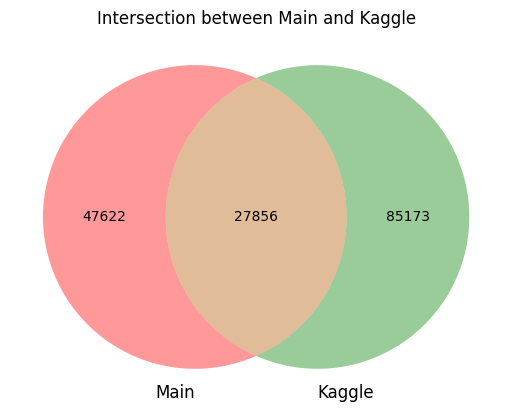

In [14]:
intersectionId(df_movies, df_movies_additional, 'Main', 'Kaggle', id_column='original_title')

More than 27,000 movies from the original database are intersected with the Kaggle dataset choosing the original_title as a common key.

In [15]:
df_movies_additional.loc[df_movies_additional['budget'] != 0].count()

imdb_id              14391
original_title       14504
original_language    14504
budget               14186
revenue              14496
release_date         14431
title                14178
dtype: int64

However, after a deeper analysis on the Kaggle dataset we realize that only ~14,000 values are not null for the budget and the revenue. So, a lot of implicit missing values were hidden in the Kaggle dataset.

Additional movie data from Kaggle where budget is not null

In [16]:
df_movies_additional_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15043 entries, 0 to 15042
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   imdb_id            14391 non-null  object 
 1   original_title     14504 non-null  object 
 2   original_language  14504 non-null  object 
 3   budget             14186 non-null  float64
 4   revenue            14496 non-null  object 
 5   release_date       14431 non-null  object 
 6   title              14178 non-null  object 
dtypes: float64(1), object(6)
memory usage: 822.8+ KB


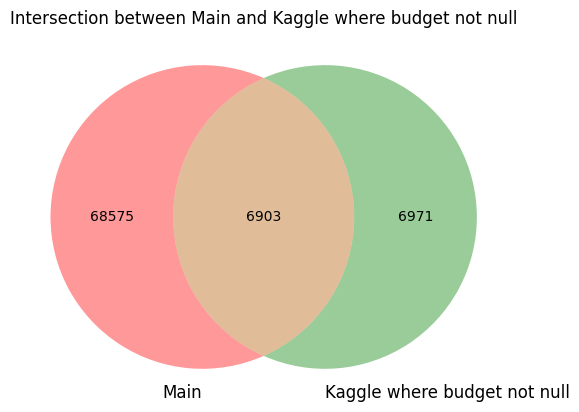

In [17]:
intersectionId(df_movies, df_movies_additional_filtered, 'Main', 'Kaggle where budget not null', id_column='original_title')

Finally, we realize that only 6,903 movies from the original database are intersected with the Kaggle dataset choosing the original_title as a common key.

This is much lower than we had hoped, which makes the dataset irrelevant in our case, as the feature revenue of the original dataset had 8401 non-zero values.

### I.2.2 Inflation dataset from Kaggle

Because we are going to study the revenue of movies it is also important to consider the Inflation by importing a dataset from Kaggle. Without adjusting for inflation, raw revenue data can be misleading, underestimating or overestimating the relative success of films from past eras. Adjusting for inflation makes analyses much more relevant and nuanced for understanding the evolution of the film industry. We make the assumption that the Consumer Price Index of the USA is representative of the rest of the world.

In [18]:
df_inflation_additional_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Yearmon  1296 non-null   datetime64[ns]
 1   CPI      1296 non-null   float64       
 2   year     1296 non-null   int32         
dtypes: datetime64[ns](1), float64(1), int32(1)
memory usage: 25.4 KB


In [19]:
df_inflation_additional_annual.describe()

,year,CPI
count,108.00000,108.000000
mean,1966.50000,81.641431
std,31.32092,79.760606
min,1913.00000,9.883333
25%,1939.75000,17.495833
50%,1966.50000,32.908333
75%,1993.25000,145.400000
max,2020.00000,258.811167


The annual inflation dataset from 1913 to 2020 will be used to readjust the revenue of movies considering the year of release.

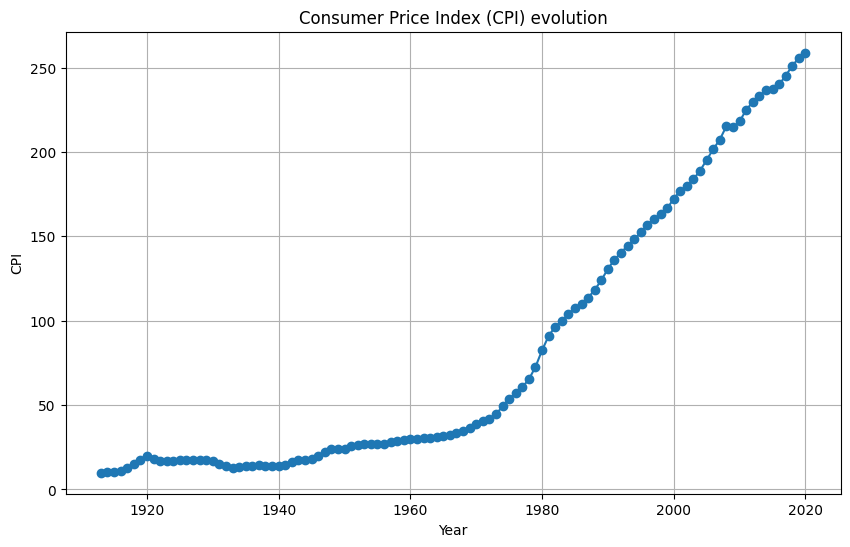

In [20]:
# plot the temporal evolution of the Consumer Price Index (CPI)
plt.figure(figsize=(10, 6))
plt.plot(df_inflation_additional_annual['year'], df_inflation_additional_annual['CPI'], marker='o')
plt.title('Consumer Price Index (CPI) evolution')
plt.xlabel('Year')
plt.ylabel('CPI')
plt.grid()
plt.show()


## III. Economics

### III.1 Dataframe for Economics part

Filtering on notna box office revenue

In [21]:
#df_movies_eco = df_movies[df_movies['revenue'].notna()]
#df_movies_eco['year'] = df_movies_eco['release_date'].dt.year

# Import dataframe for Economic part
from scriptEconomy import process_data_economy

df_movies_eco = process_data_economy()

df_movies_eco.describe()

c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/scripts\scriptEconomy.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_movies[columns_to_convert] = df_movies[columns_to_convert].applymap(eval) # Convert the columns with list of strings to list of strings
c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/scripts\scriptEconomy.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies_eco['year'] = df_movies_eco['release_date'].dt.year # Extract the year from the 'release_date' column


,wiki_id,release_date,revenue,year,revenue_adj
count,8.327000e+03,8327,8.327000e+03,8327.000000,8.327000e+03
mean,8.987038e+06,1991-07-03 00:31:18.035306880,4.826907e+07,1991.067371,1.053456e+07
min,3.217000e+03,1914-02-15 00:00:00,1.000000e+04,1914.000000,1.404459e+03
25%,1.210197e+06,1985-01-01 00:00:00,2.105039e+06,1985.000000,8.739525e+05
50%,4.032619e+06,1997-09-06 00:00:00,1.081538e+07,1997.000000,2.935405e+06
75%,1.485150e+07,2006-06-23 00:00:00,4.105011e+07,2006.000000,9.664270e+06
max,3.706127e+07,2012-10-25 00:00:00,2.782275e+09,2012.000000,8.857474e+08
std,1.013294e+07,NaN,1.124673e+08,19.703164,2.670217e+07


To carry out our study we will be able to rely on 8401 non-zero income values.

Recalculating box office revenue indexed to US inflation

<Axes: xlabel='year'>

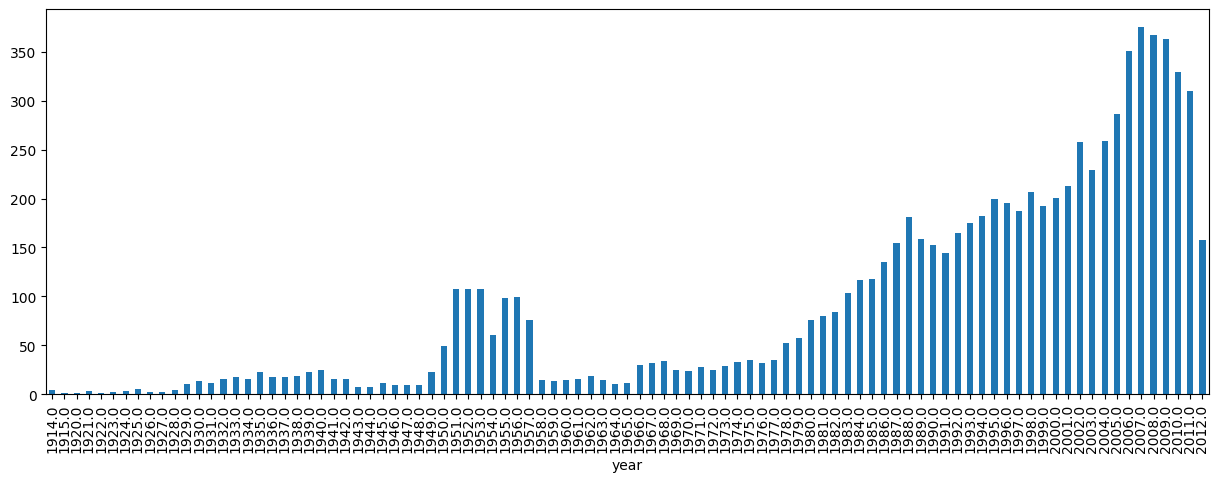

In [22]:
df_movies_eco['year'].value_counts().sort_index().plot(kind='bar', figsize=(15, 5))

Income values in the orignal dataset range from 1897 to 2012 with only one value in 1897. So, considering the CPI dataset ranges from 1914 to 2020, we remove the first revenue value and null values.

In [23]:
df_movies_eco['revenue'].notnull().sum()


np.int64(8327)

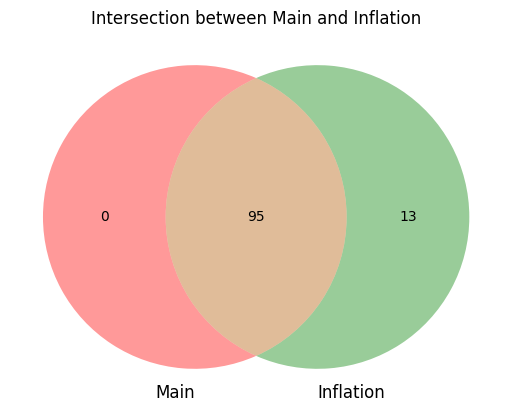

In [24]:
intersectionId(df_movies_eco, df_inflation_additional_annual, 'Main', 'Inflation', id_column='year')

Finally, the Economic analysis is conducted on a sample of 8327 movies. We notice that all the years of the selected sample of 8327 movies have a correspondance in the inflation dataset. So, we are able to calculate the income reindexed for inflation, using the midpoint year between 2012 and 1914 as a reference year (1963 in this case) to minimize edge effects.








In [25]:
df_movies_eco.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8327 entries, 0 to 81732
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   wiki_id                8327 non-null   int64         
 1   freebase_id            8327 non-null   object        
 2   original_title         8327 non-null   object        
 3   release_date           8327 non-null   datetime64[ns]
 4   revenue                8327 non-null   float64       
 5   countries              8327 non-null   object        
 6   countries_freebase_id  8327 non-null   object        
 7   year                   8327 non-null   float64       
 8   revenue_adj            8327 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 650.5+ KB


### III.2 Free exchange of goods and services

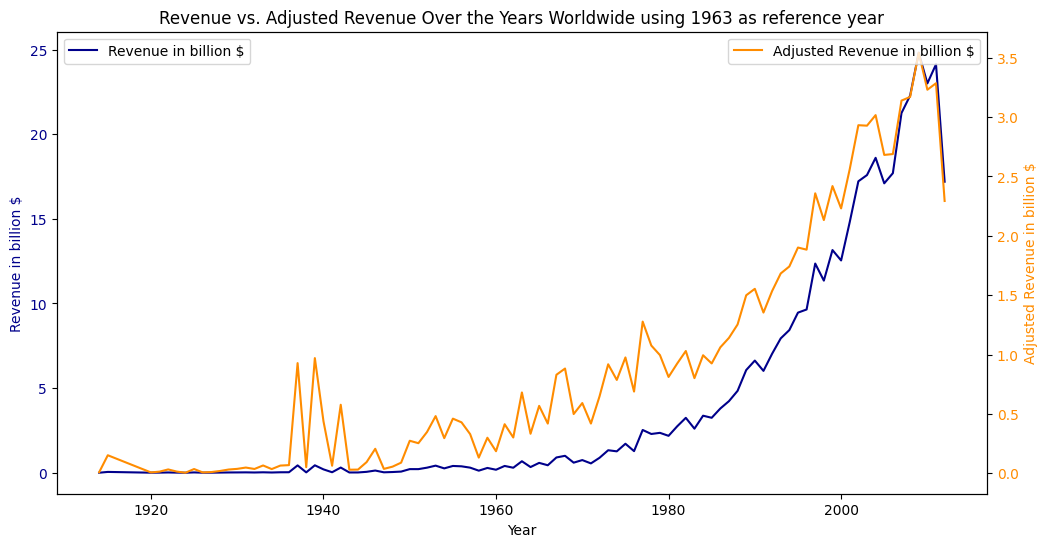

In [26]:
import matplotlib.pyplot as plt

# Créer la figure
plt.figure(figsize=(12, 6))

# Créer le premier axe y pour 'revenue'
ax1 = plt.gca()
ax1.plot(df_movies_eco.groupby('year')['revenue'].sum()/10**9, label='Revenue in billion $', color='darkblue')
ax1.set_xlabel('Year')
ax1.set_ylabel('Revenue in billion $', color='darkblue')
ax1.tick_params(axis='y', labelcolor='darkblue')

# Créer le second axe y pour 'adjusted revenue'
ax2 = ax1.twinx()
ax2.plot(df_movies_eco.groupby('year')['revenue_adj'].sum()/10**9, label='Adjusted Revenue in billion $', color='darkorange')
ax2.set_ylabel('Adjusted Revenue in billion $', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')

# Ajouter un titre
plt.title('Revenue vs. Adjusted Revenue Over the Years Worldwide using 1963 as reference year')

# Ajouter des légendes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Afficher le graphique
plt.show()


From the previous plot we observe that the computation of the value of revenue adjusted for inflation is an essential indicator for correctly interpreting the evolution of film revenues over a long period, in the context of the film industry from 1914 to 2012. we can confirm that using 1963 as the reference year helps to minimize potential edge effects that might have appeared if a more recent or much older year were used.

Observations:

   - The orange line remains relatively flat, suggesting that when adjusted to 1963 dollars, the revenue of movies has not significantly increased over time. This could imply that the apparent increase in revenue is primarily due to inflation rather than a true increase in movie profitability.
    
   - The blue line rises especially from the 1980s, reflecting an increase in nominal revenue, likely driven by more films produced higher ticket prices, broader audiences, and expanding international markets.

Finally, we can state that it is possible to address the topic of free trade in goods and services, by examining the box office revenue of films over time and potentially by splitting by country.

In [27]:
reload(sys.modules['scriptEconomy']) 
# Import dataframe for Exploded Economic part
from scriptEconomy import process_data_exploded_economy

df_movies_eco_exploded_countries = process_data_exploded_economy()

c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/scripts\scriptEconomy.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_movies[columns_to_convert] = df_movies[columns_to_convert].applymap(eval) # Convert the columns with list of strings to list of strings
c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/scripts\scriptEconomy.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies_eco['year'] = df_movies_eco['release_date'].dt.year # Extract the year from the 'release_date' column


In [28]:
df_movies_eco_exploded_countries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10985 entries, 0 to 81726
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   wiki_id                10985 non-null  int64         
 1   freebase_id            10985 non-null  object        
 2   original_title         10985 non-null  object        
 3   release_date           10985 non-null  datetime64[ns]
 4   revenue                10985 non-null  float64       
 5   countries              10985 non-null  object        
 6   countries_freebase_id  10985 non-null  object        
 7   year                   10985 non-null  float64       
 8   revenue_adj            10985 non-null  float64       
 9   region                 10985 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 944.0+ KB


In [ ]:
df_movies_eco_exploded_countries.head(10)

,wiki_id,freebase_id,original_title,release_date,revenue,countries,countries_freebase_id,year,revenue_adj,region
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,United States of America,[/m/09c7w0],2001.0,2.423278e+06,North America
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,United States of America,[/m/09c7w0],1938.0,7.823773e+06,North America
13,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,United Kingdom,[/m/07ssc],1989.0,2.510220e+06,Europe
17,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,United States of America,[/m/09c7w0],1964.0,1.009813e+08,North America
21,612710,/m/02wjqm,New Rose Hotel,1999-10-01,21521.0,United States of America,[/m/09c7w0],1999.0,3.956660e+03,North America
29,156558,/m/014k4y,Baby Boy,2001-06-27,29381649.0,United States of America,[/m/09c7w0],2001.0,5.081775e+06,North America
36,1364293,/m/04wy0v,They Knew What They Wanted,1940-01-01,932000.0,United States of America,[/m/09c7w0],1940.0,2.037537e+06,North America
49,261237,/m/01mrrd,The Gods Must Be Crazy,1980-01-01,34331783.0,South Africa,[/m/0hzlz],1980.0,1.275855e+07,Africa
53,12008535,/m/02vlsqt,Rudo y Cursi,2008-01-01,11091868.0,Mexico,"[/m/0b90_r, /m/09c7w0]",2008.0,1.577726e+06,North America
53,12008535,/m/02vlsqt,Rudo y Cursi,2008-01-01,11091868.0,United States of America,"[/m/0b90_r, /m/09c7w0]",2008.0,1.577726e+06,North America


Let's create an interactive plot to select the country

In [30]:
import plotly.graph_objects as go

# Initialize figure
fig = go.Figure()
df_movies_eco_exploded_countries['countries'] = df_movies_eco_exploded_countries['countries'].astype(str)

# Add traces for each country's data
for i, country in enumerate(df_movies_eco_exploded_countries['countries'].unique()):
    country_data = df_movies_eco_exploded_countries[df_movies_eco_exploded_countries['countries'] == country].groupby('year', as_index=False)[['revenue', 'revenue_adj']].sum()

    # Add Revenue trace
    fig.add_trace(go.Scatter(
        x=country_data['year'],
        y=country_data['revenue'],
        mode='lines+markers',
        name=f'Revenue ({country}) in $',
        visible=True if country == df_movies_eco_exploded_countries['countries'].unique()[0] else False,
        line=dict(width=2),
        marker=dict(size=6, symbol='circle'),
        yaxis='y'  # Use the primary y-axis
    ))

    # Add Adjusted Revenue trace
    fig.add_trace(go.Scatter(
        x=country_data['year'],
        y=country_data['revenue_adj'],
        mode='lines+markers',
        name=f'Adjusted Revenue ({country}) in $',
        visible=True if country == df_movies_eco_exploded_countries['countries'].unique()[0] else False,
        line=dict(width=2),
        marker=dict(size=6, symbol='square'),
        yaxis='y2'  # Use the secondary y-axis
    ))

# Create dropdown buttons for filtering by country
buttons = []
for country in df_movies_eco_exploded_countries['countries'].unique():
    visibility = [country == trace.name.split('(')[1].split(')')[0].strip() for trace in fig.data]

    button = {
        'label': country,
        'method': 'update',
        'args': [
            {'visible': visibility},  # Update visibility of traces
            {'title': f"Revenue vs Adjusted Revenue: {country}"}
        ]
    }
    buttons.append(button)

# Update layout with dropdown menu and styling
fig.update_layout(
    updatemenus=[{
        'buttons': buttons,
        'direction': 'down',
        'showactive': True,
        'x': 0.5,
        'y': 1.15,
        'xanchor': 'center',
        'yanchor': 'top'
    }],
    title={
        'text': "Revenue vs Adjusted Revenue Over the Years per Country",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=20, family='Arial, sans-serif')
    },
    xaxis=dict(
        title='Year',
        titlefont=dict(size=16),
        tickfont=dict(size=12),
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=False
    ),
    yaxis=dict(
        title='Revenue in $',
        titlefont=dict(size=16),
        tickfont=dict(size=12),
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=False
    ),
    yaxis2=dict(
        title='Adjusted Revenue in $',
        titlefont=dict(size=16),
        tickfont=dict(size=12),
        overlaying='y',
        side='right',
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=False
    ),
    legend=dict(
        title='Legend',
        x=0.01,
        y=0.99,
        bordercolor="Black",
        borderwidth=1,
        font=dict(size=12)
    ),
    plot_bgcolor='white'
)

# Add grid lines and background
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)

# Show the figure
fig.show()
fig.write_html("Rev-vs-Adj_Rev_country.html")


Let's create an interactive plot to select regions

In [31]:
import plotly.graph_objects as go


# Initialize figure
fig = go.Figure()
df_movies_eco_exploded_countries['region'] = df_movies_eco_exploded_countries['region'].astype(str)

# Add traces for each region's data
for i, region in enumerate(df_movies_eco_exploded_countries['region'].unique()):
    region_data = df_movies_eco_exploded_countries[df_movies_eco_exploded_countries['region'] == region].groupby('year', as_index=False)[['revenue', 'revenue_adj']].sum()

    # Add Revenue trace
    fig.add_trace(go.Scatter(
        x=region_data['year'],
        y=region_data['revenue'],
        mode='lines+markers',
        name=f'Revenue ({region}) in $',
        visible=True if region == df_movies_eco_exploded_countries['region'].unique()[0] else False,
        line=dict(width=2),
        marker=dict(size=6, symbol='circle'),
        yaxis='y'  # Use the primary y-axis
    ))

    # Add Adjusted Revenue trace
    fig.add_trace(go.Scatter(
        x=region_data['year'],
        y=region_data['revenue_adj'],
        mode='lines+markers',
        name=f'Adjusted Revenue ({region}) in $',
        visible=True if region == df_movies_eco_exploded_countries['region'].unique()[0] else False,
        line=dict(width=2),
        marker=dict(size=6, symbol='square'),
        yaxis='y2'  # Use the secondary y-axis
    ))

# Create dropdown buttons for filtering by region
buttons = []
for region in df_movies_eco_exploded_countries['region'].unique():
    visibility = [region == trace.name.split('(')[1].split(')')[0].strip() for trace in fig.data]

    button = {
        'label': region,
        'method': 'update',
        'args': [
            {'visible': visibility},  # Update visibility of traces
            {'title': f"Revenue vs Adjusted Revenue: {region}"}
        ]
    }
    buttons.append(button)

# Update layout with dropdown menu and styling
fig.update_layout(
    updatemenus=[{
        'buttons': buttons,
        'direction': 'down',
        'showactive': True,
        'x': 0.5,
        'y': 1.15,
        'xanchor': 'center',
        'yanchor': 'top'
    }],
    title={
        'text': "Revenue vs Adjusted Revenue Over the Years per Region",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=20, family='Arial, sans-serif')
    },
    xaxis=dict(
        title='Year',
        titlefont=dict(size=16),
        tickfont=dict(size=12),
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=False
    ),
    yaxis=dict(
        title='Revenue in $',
        titlefont=dict(size=16),
        tickfont=dict(size=12),
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=False
    ),
    yaxis2=dict(
        title='Adjusted Revenue in $',
        titlefont=dict(size=16),
        tickfont=dict(size=12),
        overlaying='y',
        side='right',
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=False
    ),
    legend=dict(
        title='Legend',
        x=0.01,
        y=0.99,
        bordercolor="Black",
        borderwidth=1,
        font=dict(size=12)
    ),
    plot_bgcolor='white'
)

# Add grid lines and background
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)

# Show the figure
fig.show()
fig.write_html("Rev-vs-Adj_Rev_region.html")


Now I want to create an interactive map that shows the market share of each country worldwide depending on the year.

In [32]:
reload(sys.modules['scriptEconomy']) 
# Import dataframe for Exploded Economic part
from scriptEconomy import calculate_market_share_economy

df_movies_eco_exploded_countries_agg = calculate_market_share_economy()

df_movies_eco_exploded_countries_agg.head(10)

c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/scripts\scriptEconomy.py:40: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/scripts\scriptEconomy.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,year,countries,revenue,total_revenue_year,market_share,log_revenue,log_market_share
0,1914,United States of America,2831728.0,2831728.0,100.000000,14.856398,4.605170
1,1915,United States of America,50000000.0,50000000.0,100.000000,17.727534,4.605170
2,1920,United States of America,4500000.0,4500000.0,100.000000,15.319588,4.605170
3,1921,United States of America,7900000.0,7900000.0,100.000000,15.882373,4.605170
4,1922,United States of America,17530973.0,17530973.0,100.000000,16.679480,4.605170
5,1923,United States of America,7668790.0,7668790.0,100.000000,15.852669,4.605170
6,1924,United States of America,2419827.0,2419827.0,100.000000,14.699207,4.605170
7,1925,United Kingdom,2000000.0,22262001.0,8.983918,14.508658,2.195436
8,1925,United States of America,20262001.0,22262001.0,91.016082,16.824258,4.511036
9,1926,United States of America,4000000.0,4000000.0,100.000000,15.201805,4.605170


In [33]:
df_movies_eco_exploded_countries_agg["log_market_share"].describe()

count    908.000000
mean      -0.817004
std        2.993238
min      -10.183469
25%       -2.802404
50%       -0.782555
75%        1.149414
max        4.605170
Name: log_market_share, dtype: float64

In [34]:
import pandas as pd
import plotly.express as px

# Create the choropleth map
fig = px.choropleth(
    df_movies_eco_exploded_countries_agg,
    locations="countries",  # Column with country names
    locationmode="country names",  # If ISO codes, use "ISO-3" here
    color="log_market_share",  # Data for color intensity
    animation_frame="year",  # Add animation by year
    color_continuous_scale="Blues",  # Color scale
    range_color=[df_movies_eco_exploded_countries_agg["log_market_share"].min(), df_movies_eco_exploded_countries_agg["log_market_share"].max()],  # Fix scale range to min and max market share
    title="Market Share in terms of Revenue Worldwide per Year"
)

# Improve layout (optional)
fig.update_layout(
    geo=dict(
        showframe=False,
        projection_type='equirectangular'
    ),
    title_x=0.5  # Center title
)

# Show the figure
fig.show()
fig.write_html("Rev_Market-share.html")



On a montré que les parts du marché mondial du cinéma se sont peu à peu diversifiées ce qui témoigne d'une économie mondiale du cinéma qui s'est mondialisée

### III.3 Co-productions evolution

Another interesting point is to test potential correlation between co-productions box office revenue by analyzing the revenue of film industry over time depending on the number of co-productions.

Pour faire cela on va compter le nombre de co productions par pays puis représenter le revenue du pays au cours des années avec en fond un stack bar chart qui va montrer le nombre de co productions

On cherche donc à calculer par années, le nombre de co-productions de chaque pays

On crée un dataframe avec tous les wiki_id des films co produits

In [35]:
#df_movies_eco_coprod = df_movies_eco_exploded_countries.groupby(["wiki_id"])["countries"].count().reset_index()

#df_movies_eco_coprod = df_movies_eco_coprod[df_movies_eco_coprod["countries"] > 1]

#df_movies_eco_coprod.countries.value_counts()

On filtre notre dataframe pour garder que les films co produits

In [36]:
reload(sys.modules['scriptEconomy']) 
# Import dataframe for Exploded Economic part
from scriptEconomy import movies_co_productions

df_movies_eco_exploded_countries_coprod = movies_co_productions()

df_movies_eco_exploded_countries_coprod.head(10)

c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/scripts\scriptEconomy.py:40: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/scripts\scriptEconomy.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,wiki_id,freebase_id,original_title,release_date,revenue,countries,countries_freebase_id,year,revenue_adj,region
53,12008535,/m/02vlsqt,Rudo y Cursi,2008-01-01,11091868.0,Mexico,"[/m/0b90_r, /m/09c7w0]",2008.0,1.577726e+06,North America
53,12008535,/m/02vlsqt,Rudo y Cursi,2008-01-01,11091868.0,United States of America,"[/m/0b90_r, /m/09c7w0]",2008.0,1.577726e+06,North America
164,1031231,/m/03_wh5,"Black Cat, White Cat",1998-09-10,351447.0,France,"[/m/0f8l9c, /m/087vz, /m/0345h]",1998.0,6.602769e+04,Europe
164,1031231,/m/03_wh5,"Black Cat, White Cat",1998-09-10,351447.0,Slovenia,"[/m/0f8l9c, /m/087vz, /m/0345h]",1998.0,6.602769e+04,Europe
164,1031231,/m/03_wh5,"Black Cat, White Cat",1998-09-10,351447.0,Germany,"[/m/0f8l9c, /m/087vz, /m/0345h]",1998.0,6.602769e+04,Europe
175,196176,/m/01bwgr,Straw Dogs,1971-11-03,11148828.0,United States of America,"[/m/09c7w0, /m/07ssc]",1971.0,8.432176e+06,North America
175,196176,/m/01bwgr,Straw Dogs,1971-11-03,11148828.0,United Kingdom,"[/m/09c7w0, /m/07ssc]",1971.0,8.432176e+06,Europe
197,748616,/m/03813g,"Spring, Summer, Fall, Winter... and Spring",2003-08-14,9524745.0,South Korea,"[/m/06qd3, /m/0345h]",2003.0,1.585660e+06,East and Southeast Asia
197,748616,/m/03813g,"Spring, Summer, Fall, Winter... and Spring",2003-08-14,9524745.0,Germany,"[/m/06qd3, /m/0345h]",2003.0,1.585660e+06,Europe
222,3033993,/m/08m1s2,Becoming Jane,2007-03-02,37311672.0,Ireland,"[/m/03rt9, /m/07ssc]",2007.0,5.511028e+06,Europe


On crée un dataframe qui va par année déterminer le nombre de coproduction de chaque pays

In [37]:
reload(sys.modules['scriptEconomy']) 
# Import dataframe for Exploded Economic part
from scriptEconomy import coprod_countries_yearly

df_movies_eco_coprod_countries_count = coprod_countries_yearly()

df_movies_eco_coprod_countries_count.head(10)

c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/scripts\scriptEconomy.py:40: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/scripts\scriptEconomy.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,year,countries,co_production_count
0,1925,United Kingdom,1
1,1925,United States of America,1
2,1930,Germany,1
3,1940,Malaysia,1
4,1940,United States of America,1
5,1942,United Kingdom,1
6,1942,United States of America,1
7,1945,United Kingdom,1
8,1950,United Kingdom,2
9,1950,United States of America,2


In [38]:
import plotly.graph_objects as go

# Initialize figure
fig = go.Figure()
df_movies_eco_exploded_countries['countries'] = df_movies_eco_exploded_countries['countries'].astype(str)

# Add traces for each country's data
for i, country in enumerate(df_movies_eco_exploded_countries['countries'].unique()):
    country_data = df_movies_eco_exploded_countries[df_movies_eco_exploded_countries['countries'] == country].groupby('year', as_index=False)[['revenue', 'revenue_adj']].sum()

    # Add Bar trace (with transparency)
    fig.add_trace(go.Bar(
        x=country_data['year'],
        y=df_movies_eco_coprod_countries_count['co_production_count'],  # Count of co-productions
        name=f'Co-productions ({country})',
        marker=dict(opacity=0.5),
        visible=True if country == df_movies_eco_exploded_countries['countries'].unique()[0] else False,
        yaxis='y2'  # Use the primary y-axis
    ))

    fig.add_trace(go.Scatter(
        x=country_data['year'],
        y=country_data['revenue_adj'],
        mode='lines+markers',
        name=f'Adjusted Revenue in $ ({country})',
        visible=True if country == df_movies_eco_exploded_countries['countries'].unique()[0] else False,
        line=dict(width=2),
        marker=dict(size=6, symbol='square'),
        yaxis='y'  # Use the secondary y-axis
    ))

# Create dropdown buttons for filtering by country
buttons = []
for country in df_movies_eco_exploded_countries['countries'].unique():
    visibility = [country == trace.name.split('(')[1].split(')')[0].strip() for trace in fig.data]

    button = {
        'label': country,
        'method': 'update',
        'args': [
            {'visible': visibility},  # Update visibility of traces
            {'title': f"Adjusted Revenue and Co-Productions: {country}"}
        ]
    }
    buttons.append(button)

# Update layout with dropdown menu and styling
fig.update_layout(
    updatemenus=[{
        'buttons': buttons,
        'direction': 'down',
        'showactive': True,
        'x': 0.5,
        'y': 1.15,
        'xanchor': 'center',
        'yanchor': 'top'
    }],
    title={
        'text': "Adjusted Revenue and Co-Productions Over the Years",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=20, family='Arial, sans-serif')
    },
    xaxis=dict(
        title='Year',
        titlefont=dict(size=16),
        tickfont=dict(size=12),
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=False
    ),
    yaxis=dict(
        title='Adjusted Revenue in $',
        titlefont=dict(size=16),
        tickfont=dict(size=12),
        overlaying='y2',
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=False
    ),
    yaxis2=dict(
        title='# Co-Productions',
        titlefont=dict(size=16),
        tickfont=dict(size=12),
        side='right',
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=False
    ),
    legend=dict(
        title='Legend',
        x=0.01,
        y=0.99,
        bordercolor="Black",
        borderwidth=1,
        font=dict(size=12)
    ),
    plot_bgcolor='white'
)

# Add grid lines and background
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)

# Show the figure
fig.show()
fig.write_html("Rev_vs_Co-prod.html")

On va créer un dataframe qui par année va déterminer les couples de pays et le nombre de co productions

In [39]:
reload(sys.modules['scriptEconomy']) 
# Import dataframe for Exploded Economic part
from scriptEconomy import coprod_couple_countries_yearly

df_movies_eco_coprod_country_country = coprod_couple_countries_yearly()

df_movies_eco_coprod_country_country.head(10)

c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/scripts\scriptEconomy.py:40: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/scripts\scriptEconomy.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,year,country_1,country_2,co_production_count
0,1925,United Kingdom,United States of America,1
1,1930,Germany,Germany,1
2,1940,Malaysia,United States of America,1
3,1942,United Kingdom,United States of America,1
4,1945,United Kingdom,United Kingdom,1
5,1950,United Kingdom,United States of America,2
6,1951,France,India,1
7,1951,France,United Kingdom,1
8,1951,France,United States of America,1
9,1951,India,United Kingdom,1


In [40]:
# plotting the map with a slider
import plotly.express as px
from shapely.geometry import Point
import geopandas as gpd

# charging geographical data 
world = gpd.read_file('data/map/ne_110m_admin_0_countries.shp')

# changing data into the right projection to compute the centroids
world_projected = world.to_crs("EPSG:3395")
world_projected["centroid"] = world_projected.geometry.centroid
world["centroid"] = world_projected["centroid"].to_crs(world.crs) # converting back the centroids into the right projection

# Linking each centroid with a country
centroids = world.set_index("NAME")["centroid"] 
df_movies_eco_coprod_country_country["coord1"] = df_movies_eco_coprod_country_country["country_1"].map(centroids)
df_movies_eco_coprod_country_country["coord2"] = df_movies_eco_coprod_country_country["country_2"].map(centroids)

#Fixing centroid of USA (without Alaska), Canada, Norway and France
df_movies_eco_coprod_country_country.loc[df_movies_eco_coprod_country_country['country_1'] == 'United States of America', 'coord1'] = Point(-98.35, 39.50)
df_movies_eco_coprod_country_country.loc[df_movies_eco_coprod_country_country['country_2'] == 'United States of America', 'coord2'] = Point(-98.35, 39.50)

df_movies_eco_coprod_country_country.loc[df_movies_eco_coprod_country_country['country_1'] == 'Canada', 'coord1'] = Point(-105, 56.8)
df_movies_eco_coprod_country_country.loc[df_movies_eco_coprod_country_country['country_2'] == 'Canada', 'coord2'] = Point(-105, 56.8)

df_movies_eco_coprod_country_country.loc[df_movies_eco_coprod_country_country['country_1'] == 'Norway', 'coord1'] = Point(10, 62)
df_movies_eco_coprod_country_country.loc[df_movies_eco_coprod_country_country['country_2'] == 'Norway', 'coord2'] = Point(10, 62)

df_movies_eco_coprod_country_country.loc[df_movies_eco_coprod_country_country['country_1'] == 'France', 'coord1'] = Point(2.25, 46.32)
df_movies_eco_coprod_country_country.loc[df_movies_eco_coprod_country_country['country_2'] == 'France', 'coord2'] = Point(2.25, 46.32)

# Creating the figure
fig = px.scatter_geo(
    world,  # GeoDataFrame
    #locations="ISO_A3",  # countries id
    #hover_name="NAME",  # names to print
    title="Co-productions Between Countries Over the Years",
    
)

# Adding the links from links_occurence df
traces = []
for year in df_movies_eco_coprod_country_country["year"].unique():
    df_year = df_movies_eco_coprod_country_country[df_movies_eco_coprod_country_country["year"] == year]
    df_year = df_year.dropna(subset=["coord1", "coord2"])

    trace = px.scatter_geo(
        world,  # Carte de base
        locations="ISO_A3",
        hover_name="NAME",
        title=f"Interactions between countries ({year})"
    )
    for _, row in df_year.iterrows():
        fig.add_scattergeo(
            lon=[row["coord1"].x, row["coord2"].x],
            lat=[row["coord1"].y, row["coord2"].y],
            mode="lines",
            line=dict(width=row["co_production_count"] / 30, color="blue"),
            name=f"{row['country_1']} ↔ {row['country_2']} ({row['year']})",
            opacity=1,
            showlegend=False
        )

    traces.append(trace)

# Adding a slider and centering the title
fig.update_layout(
    showlegend=False, 
    sliders=[
        dict(
            active=0,
            currentvalue={"prefix": "Year: "},
            pad={"t": 50},
            steps=[
                dict(
                    label=str(year),
                    method="update",
                    args=[{"visible": [i <= idx for i in range(len(traces))]}],
                )
                for idx, year in enumerate(df_movies_eco_coprod_country_country["year"].unique())
            ],
        )
    ],
    title={
        "text": "Co-productions Between Countries Over the Years",  # Titre du graphique
        "x": 0.5,  # Centre le titre (0 = gauche, 1 = droite)
        "xanchor": "center",  # Ancrage horizontal
        "yanchor": "top"  # Ancrage vertical
    }
)

fig.show()
fig.write_html("Co-prod_countries.html")



On fait maintenant une étude par période de 5 ans en rajoutant le revenu sur la période

In [41]:
reload(sys.modules['scriptEconomy']) 
# Import dataframe for Exploded Economic part
from scriptEconomy import coprod_couple_countries_period

df_movies_eco_coprod_country_country_5 = coprod_couple_countries_period()

df_movies_eco_coprod_country_country_5.head(10)


c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/scripts\scriptEconomy.py:40: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/scripts\scriptEconomy.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,period,country_1,country_2,co_production_count
0,1925,United Kingdom,United States of America,1
1,1930,Germany,Germany,1
2,1940,Malaysia,United States of America,1
3,1940,United Kingdom,United States of America,1
4,1945,United Kingdom,United Kingdom,1
5,1950,France,India,1
6,1950,France,United Kingdom,1
7,1950,France,United States of America,1
8,1950,Germany,United States of America,1
9,1950,India,United Kingdom,1


On suppose que si un film est co produit la recette du film revient à tous les pays qui ont co produits le film

In [42]:
import numpy as np
import pandas as pd

# Create period based on 5-year intervals
#df_movies_eco_exploded_countries['period'] = (df_movies_eco_exploded_countries['year'] // 5) * 5

# Group by Year and Country, sum revenue
#df_movies_eco_exploded_countries_agg_5 = df_movies_eco_exploded_countries.groupby(["period", "countries"])["revenue"].sum().reset_index()

# Calculate log of revenue over the period
#df_movies_eco_exploded_countries_agg_5['log_revenue_period'] = df_movies_eco_exploded_countries_agg_5["revenue"].apply(lambda x: np.log(x) if x > 0 else 0)

# Convert year to integer (if not already)
#df_movies_eco_exploded_countries_agg_5['period'] = df_movies_eco_exploded_countries_agg_5['period'].astype(int)


#df_movies_eco_exploded_countries_agg_5 = df_movies_eco_exploded_countries_agg_5[df_movies_eco_exploded_countries_agg_5.countries != "Republic of Serbia"]

#df_movies_eco_exploded_countries_agg_5 = df_movies_eco_exploded_countries_agg_5[df_movies_eco_exploded_countries_agg_5.countries != "The Bahamas"]

#df_movies_eco_exploded_countries_agg_5 = df_movies_eco_exploded_countries_agg_5[df_movies_eco_exploded_countries_agg_5.countries != "Bosnia and Herzegovina"]

# Show the result

reload(sys.modules['scriptEconomy']) 
# Import dataframe for Exploded Economic part
from scriptEconomy import revenue_period

df_movies_eco_exploded_countries_agg_5 = revenue_period()

df_movies_eco_exploded_countries_agg_5.head(10)


c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/scripts\scriptEconomy.py:40: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

c:\Users\aurel\ADA_project_2024\ada-2024-project-teamcsx24\src/scripts\scriptEconomy.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,period,countries,revenue,log_revenue_period
0,1910,United States of America,2831728.0,14.856398
1,1915,United States of America,50000000.0,17.727534
2,1920,United States of America,40019590.0,17.504880
3,1925,United Kingdom,2000000.0,14.508658
4,1925,United States of America,56797001.0,17.854994
5,1930,Germany,155964.0,11.957380
6,1930,United States of America,98801563.0,18.408624
7,1935,United Kingdom,3252000.0,14.994781
8,1935,United States of America,956102187.0,20.678375
9,1940,India,219000.0,12.296827


In [43]:
import plotly.express as px
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd

# Charger les données géographiques
world = gpd.read_file('data/map/ne_110m_admin_0_countries.shp')

# Projection pour calculer les centroïdes
world_projected = world.to_crs("EPSG:3395")
world_projected["centroid"] = world_projected.geometry.centroid
world["centroid"] = world_projected["centroid"].to_crs(world.crs)  # Reprojection des centroïdes

# Associer chaque pays à son centroïde
centroids = world.set_index("NAME")["centroid"]

# Fixer manuellement les centroïdes pour certains pays
fix_coords = {
    'United States of America': Point(-98.35, 39.50),
    'Canada': Point(-105, 56.8),
    'Norway': Point(10, 62),
    'France': Point(2.25, 46.32)
}

# Appliquer les centroïdes corrigés
centroids.update(pd.Series(fix_coords))

# Associer les centroïdes corrigés au DataFrame des co-productions
df_movies_eco_coprod_country_country_5["coord1"] = df_movies_eco_coprod_country_country_5["country_1"].map(centroids)
df_movies_eco_coprod_country_country_5["coord2"] = df_movies_eco_coprod_country_country_5["country_2"].map(centroids)

# Ajouter les revenus cumulés avec centroïdes corrigés
df_revenue = df_movies_eco_exploded_countries_agg_5.groupby(['countries', 'period'])['log_revenue_period'].sum().reset_index()
df_revenue['centroid'] = df_revenue['countries'].map(centroids)

# Création de la carte avec les liens de co-production et les bulles de revenu
fig = px.scatter_geo(
    world,  # Carte de base
    #locations="ISO_A3",
    #hover_name="NAME",
    title="Co-productions Between Countries with Revenue Over the Years"
)

# Ajouter les liens de co-production
for period in df_movies_eco_coprod_country_country_5["period"].unique():
    df_period = df_movies_eco_coprod_country_country_5[df_movies_eco_coprod_country_country_5["period"] == period]
    df_period = df_period.dropna(subset=["coord1", "coord2"])

    for _, row in df_period.iterrows():
        fig.add_scattergeo(
            lon=[row["coord1"].x, row["coord2"].x],
            lat=[row["coord1"].y, row["coord2"].y],
            mode="lines",
            line=dict(width=max(1, row["co_production_count"] / 30), color="blue"),
            name=f"{row['country_1']} ↔ {row['country_2']} ({period})",
            opacity=0.7,
            showlegend=False
        )

# Ajouter les bulles de revenu avec une couleur unique
for period in df_revenue["period"].unique():
    df_period_revenue = df_revenue[df_revenue["period"] == period]
    fig.add_scattergeo(
        lon=df_period_revenue['centroid'].apply(lambda x: x.x if pd.notnull(x) else None),
        lat=df_period_revenue['centroid'].apply(lambda x: x.y if pd.notnull(x) else None),
        text=df_period_revenue['countries'] + ": " + df_period_revenue['log_revenue_period'].astype(str),
        marker=dict(
            size=df_period_revenue['log_revenue_period'] / 1,  # Ajuster selon les données
            color="orange",  # Couleur unique pour toutes les bulles
            opacity=0.6,
            line=dict(width=1, color="black")
        ),
        name=f"Revenues ({period})",
        showlegend=False
    )

# Configuration du slider
fig.update_layout(
    sliders=[
        dict(
            active=0,
            currentvalue={"prefix": "Period: "},
            pad={"t": 50},
            steps=[
                dict(
                    label=str(period),
                    method="update",
                    args=[
                        {"visible": [f"({period})" in trace.name for trace in fig.data]},
                        {"title": f"Co-productions and log of the Revenues for the period between {period} and the 5 years before"}
                    ],
                )
                for period in sorted(df_movies_eco_coprod_country_country_5["period"].unique())
            ],
        )
    ],
    title={
        "text": "Co-productions and Revenues Over the Years",  
        "x": 0.5,  
        "xanchor": "center",  
        "yanchor": "top"  
    }
)

fig.show()
fig.write_html("Co-prod_Revenue_map.html")


From the previous revenue analysis and the dataframe of co-production countries we can state on the influence of co-productions on the revenue as a witness to globalization.

From the previous co-production dataframe, we can construct a co-occurrence matrix that records the number of movies co-produced by each pair of countries. For movies involving multiple countries, each unique country pair’s count is incremented by one. For single-country productions, only that country’s self-pair count increases by one. This matrix will be visualized in a heatmap to reveal the closeness between countries based on co-production frequency, with countries that co-produce more frequently highlighted.

Finally, the conclusion of the Economics part will be a geopandas map as described before that will show the evolution coproduction over time and the size of the film industry in each country.